# ДЗ12 — Кластеризація даних Concrete



In [1]:
import pandas as pd
import numpy as np
import pickle
import io
import matplotlib.pyplot as plt

from google.colab import files
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [2]:
uploaded = files.upload()

filename = list(uploaded.keys())[0]
datasets = pickle.load(io.BytesIO(uploaded[filename]))

df = datasets['concrete']
print(df.shape)
df.info()
df.head()

Saving mod_05_topic_10_various_data.pkl to mod_05_topic_10_various_data.pkl
(427, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427 entries, 0 to 426
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Cement               427 non-null    float64
 1   BlastFurnaceSlag     427 non-null    float64
 2   FlyAsh               427 non-null    float64
 3   Water                427 non-null    float64
 4   Superplasticizer     427 non-null    float64
 5   CoarseAggregate      427 non-null    float64
 6   FineAggregate        427 non-null    float64
 7   CompressiveStrength  427 non-null    float64
dtypes: float64(8)
memory usage: 26.8 KB


,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,CompressiveStrength
0,102.0,153.0,0.0,192.0,0.0,887.0,942.0,25.46
1,108.3,162.4,0.0,203.5,0.0,938.2,849.0,29.23
2,116.0,173.0,0.0,192.0,0.0,909.8,891.9,31.02
3,122.6,183.9,0.0,203.5,0.0,958.2,800.1,33.19
4,132.0,206.5,160.9,178.9,5.5,866.9,735.6,33.31


In [3]:
# Feature engineering: кількість компонентів у суміші
ingredient_cols = df.columns.drop('CompressiveStrength')
df['Components'] = (df[ingredient_cols] > 0).sum(axis=1)

df['Components'].value_counts().sort_index()

,count
Components,
4,69
5,67
6,171
7,120


In [4]:
# Нормалізація ознак (без CompressiveStrength)
feature_cols = df.columns.drop('CompressiveStrength')

scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(df[feature_cols]),
    columns=feature_cols
)

X_scaled.head()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Components
0,-1.571417,0.785676,-0.937685,0.424376,-1.249389,-0.834174,2.426039,-0.783621
1,-1.510484,0.892770,-0.937685,1.021584,-1.249389,-0.224074,1.155086,-0.783621
2,-1.436011,1.013536,-0.937685,0.424376,-1.249389,-0.562489,1.741364,-0.783621
3,-1.372177,1.137720,-0.937685,1.021584,-1.249389,0.014246,0.486810,-0.783621
4,-1.281261,1.395202,1.491447,-0.255922,-0.230502,-1.073686,-0.394658,1.173140


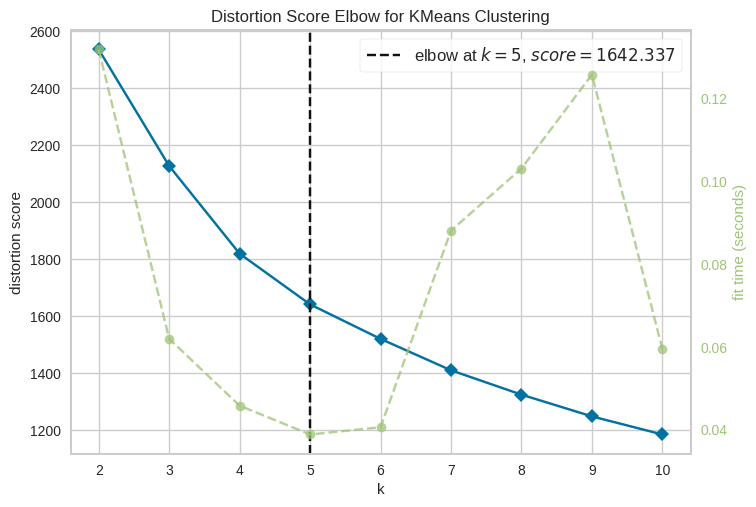


Оптимальне k = 5


In [5]:
# Визначення оптимального k методом ліктя
model = KMeans(random_state=42, n_init=10)
visualizer = KElbowVisualizer(model, k=(2, 11))

visualizer.fit(X_scaled)
visualizer.show()

optimal_k = visualizer.elbow_value_
print(f'\nОптимальне k = {optimal_k}')

In [6]:
# K-Means кластеризація
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

df['Cluster'].value_counts().sort_index()

,count
Cluster,
0,84
1,85
2,118
3,53
4,87


In [7]:
# Описова статистика по кластерах (медіани)
medians = df.groupby('Cluster').median()
medians['Count'] = df.groupby('Cluster').size()

medians

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,CompressiveStrength,Components,Count
Cluster,,,,,,,,,,
0,212.3,0.00,125.2,169.95,9.9,1002.0,795.55,39.880,6.0,84
1,186.2,183.40,0.0,190.00,0.0,977.0,734.30,37.430,5.0,85
2,193.0,119.25,116.0,193.55,8.5,879.6,744.10,33.175,7.0,118
3,356.0,121.00,0.0,162.00,10.0,914.3,803.70,59.000,6.0,53
4,342.0,0.00,0.0,186.00,0.0,1040.0,774.00,36.940,4.0,87


## Висновки

1. **Feature Engineering:** Додано ознаку `Components` — кількість ненульових інгредієнтів у кожному зразку бетону.

2. **Нормалізація:** Всі ознаки масштабовано за допомогою StandardScaler для коректної роботи K-Means.

3. **Оптимальне k:** Метод ліктя (KElbowVisualizer) визначив оптимальну кількість кластерів.

4. **Аналіз кластерів:** Медіанні значення дозволяють інтерпретувати кожен кластер за складом компонентів, віком та міцністю на стиск. Кластери відрізняються за кількістю використаних компонентів, співвідношенням цементу/води/добавок та кінцевою міцністю.